In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from edward.models import Normal
import edward as ed
from sklearn.kernel_ridge import KernelRidge

In [2]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

In [3]:
W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# x = x_train
x = tf.placeholder(tf.float32, [None, 1])
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [4]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [5]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={x: x_train, y: y_train})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 7.902


In [6]:
y_post = ed.copy(y, {W_0: qW_0, b_0: qb_0, 
                     W_1: qW_1, b_1: qb_1}).eval(feed_dict={x: x_train})

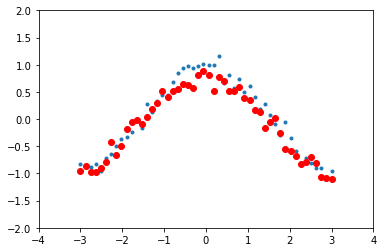

In [7]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, marker='.')
ax.scatter(x_train, y_post, c='r')
ax.set_xlim((-4, 4))
ax.set_ylim((-2, 2))
plt.show()

In [8]:
def visualize(x_data, y_data, W_0, b_0, W_1, b_1, n_samples=10, n_pts=100):
    plt.scatter(x_data, y_data)
    inputs = np.linspace(-6, 6, n_pts).reshape(n_pts, 1).astype(np.float32)
    draws = []
    for ns in range(n_samples):
        outputs = ed.copy(y, {W_0: qW_0, b_0: qb_0, 
                              W_1: qW_1, b_1: qb_1}).eval(feed_dict={x: inputs})
        draws.append(outputs.reshape(-1))
    mu = np.mean(np.array(draws), axis=0)
    std = np.std(np.array(draws), axis=0)
    plt.plot(inputs.reshape(-1), mu, c='r')
    plt.fill_between(inputs.reshape(-1), mu-2*std, mu+2*std, color='grey', alpha='0.5')
    plt.show()

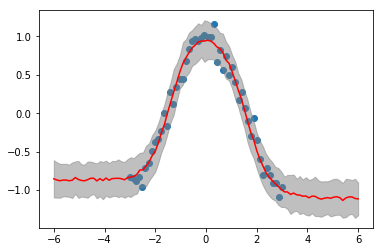

In [9]:
visualize(x_train, y_train, qW_0, qb_0, qW_1, qb_1, n_samples=100)